# DataMining First Report

# 1. 데이터 불러오기

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib import rc # 한글 그래픽 처리
import seaborn as sns # r에서 ggplot이라 생각하면됨. 쓸때 한글처리 주의.
%matplotlib inline 
plt.rc('font', family='Malgun Gothic') # 한글의 폰트를 맑은고딕 사용
plt.rc('axes', unicode_minus=False)

In [2]:
hds = pd.read_csv('hds_train.csv',engine='python',encoding='cp949')
hds.iloc[:,14:18] = hds.iloc[:,14:18].fillna(0) # 나머지 구매 비율을 보았을때 1이므로 0을 넣는것이 확실함.
hds['주중주말'] = hds['주방문요일'].map(lambda x: 0 if x in ['월','화','수','목','금'] else 1 ) # 주중과 주말로 구분하면 남녀를 잘 예측할 수 있을것 같아 삽입.
y_custid = hds[['custid','gender']]  # 추후에 custid기준 gender합치기 위해 분리.
hds.head(2)
# 1은 주말, 0은주중 

,custid,총구매액,총구매건수,평균구매액,최대구매액,총할인액,평균할인액,평균할부개월수,최대할부개월수,구입브랜드수,...,여름구매비율,가을구매비율,겨울구매비율,저녁구매비율,주구매브랜드,주구매코너,주구매시간,주방문요일,gender,주중주말
0,0,1742000,11,158363.636364,455000,174200,15836.363636,2.818182,3,7,...,0.363636,0.272727,0.272727,0.818182,크리니크,수입종합화장품,19.0,일,1,1
1,1,2772100,26,106619.230769,393000,56630,2178.076923,2.461538,3,19,...,0.346154,0.230769,0.038462,0.115385,겐조수입의류,수입부띠끄,16.0,토,1,1


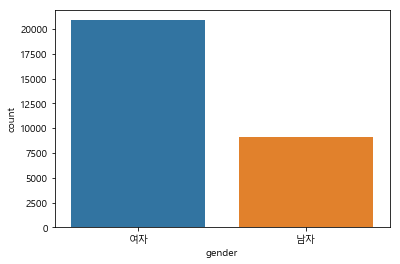

In [3]:
# Train 데이터의 남녀 숫자 및 비율 확인을 위한 그래프 
sns.countplot(x=hds['gender']).set_xticklabels(["여자",'남자'])
plt.show()

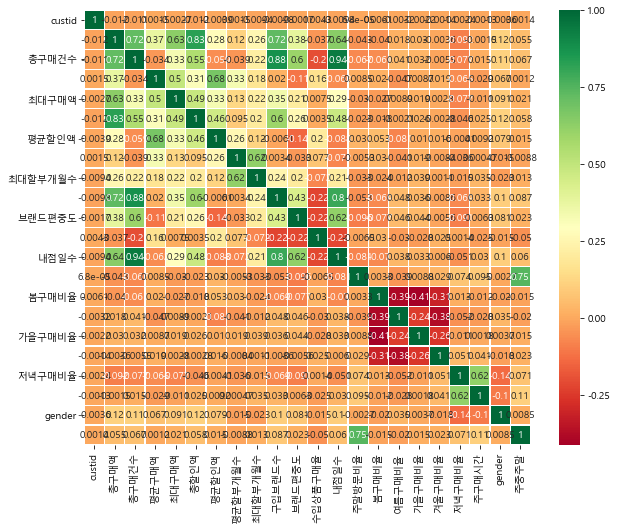

In [4]:
# 상관관계 plot을 통해 전체적인 상관관계 확인
sns.heatmap(hds.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [5]:
hds_test = pd.read_csv('hds_test.csv',engine='python',encoding='cp949')
hds_test['주중주말'] = hds_test['주방문요일'].map(lambda x: 0 if x in ['월','화','수','목','금'] else 1 )
hds_test.head(2)

,custid,총구매액,총구매건수,평균구매액,최대구매액,총할인액,평균할인액,평균할부개월수,최대할부개월수,구입브랜드수,...,봄구매비율,여름구매비율,가을구매비율,겨울구매비율,저녁구매비율,주구매브랜드,주구매코너,주구매시간,주방문요일,주중주말
0,30000,2078240,27,76971.851852,448000,77780,2880.740741,1.222222,3,16,...,0.333333,0.185185,0.148148,0.333333,0.518519,식품,진케주얼,18.0,일,1
1,30001,4158320,27,154011.851852,812000,118070,4372.962963,1.740741,3,19,...,0.333333,0.333333,0.111111,0.222222,0.222222,식품,캐쥬얼구두,17.0,일,1


In [6]:
# train data 및 test데이터를 합쳐서 주구매 시간을 예측하는데 이용함 -> data의 갯수를 늘려 좀더 정확한 NULL값 처리를 위해
timing = pd.concat([hds.drop(['gender'],axis=1),hds_test])
timing.head()

,custid,총구매액,총구매건수,평균구매액,최대구매액,총할인액,평균할인액,평균할부개월수,최대할부개월수,구입브랜드수,...,봄구매비율,여름구매비율,가을구매비율,겨울구매비율,저녁구매비율,주구매브랜드,주구매코너,주구매시간,주방문요일,주중주말
0,0,1742000,11,158363.636364,455000,174200,15836.363636,2.818182,3,7,...,0.090909,0.363636,0.272727,0.272727,0.818182,크리니크,수입종합화장품,19.0,일,1
1,1,2772100,26,106619.230769,393000,56630,2178.076923,2.461538,3,19,...,0.384615,0.346154,0.230769,0.038462,0.115385,겐조수입의류,수입부띠끄,16.0,토,1
2,2,3750850,11,340986.363636,1416000,255090,23190.000000,3.454545,12,7,...,0.000000,0.272727,0.454545,0.272727,0.363636,노티카,가전특정,19.0,수,0
3,3,2300500,30,76683.333333,621000,91660,3055.333333,2.666667,5,21,...,0.300000,0.400000,0.100000,0.200000,0.400000,라코스테,골프(LC),18.0,목,0
4,4,1045000,4,261250.000000,560000,21800,5450.000000,4.500000,10,4,...,0.000000,1.000000,0.000000,0.000000,0.000000,리츠,니트웨어,14.0,목,0


# 2. 범주형 데이터 정제하기

In [7]:
# corner별로 비슷한 말이지만 다른게 추가되어 있어 분류에 영향을 준다고 생각한 변수들의 대표성 띄는 언어를 추출해 비슷한 것으로 통합시킴.
corner = ['골프','화장품','행사','문구','향수','스포츠','부띠끄','슈즈','구두','니트','TV','아동','장신구','전화기','인텔리젼스']

timing['주구매코너'] = timing['주구매코너'].str.replace(r'^진[가-힣]{2}얼$','진캐주얼') # 캐주얼이 캐쥬얼 케주얼 있어서.. 
timing['주구매코너'] = timing['주구매코너'].str.replace(r'.*모피.*|.*피혁.*','모피피혁') # 모피 피혁 구분
timing['주구매코너'] = timing['주구매코너'].str.replace(r'^영.*','영') # 영 -> 아이들 구분 가능 
for i in corner:
    timing['주구매코너'] = timing['주구매코너'].str.replace(r'.*'+i+'.*',i)
timing['주구매코너'].nunique()
# 범주의 값을 206개로 줄임.
# 일단 제거 내용은 오타 및 다양한 내용물이 있는것 위주로 적용 -> 추후에 그래프를 그려보면 유의미한 변수가 될수도 있을것이라 생각함. 

206

In [8]:
# Brand뒤에 스포츠, 신발 등 특정 단어가 들어간경우 그 브랜드의 이름을 추출해 뒤의 값을 제거해주기 위해 사용 
brandname = ['코오롱', '블루돌핀', '닥터마틴', '레노마', '나이키','입생로랑','금양','닥스','쌈지','드봉','까르띠에','세린느','니나리찌','에이테스토니','막스앤스펜서','비앙카', '캘빈클라인', '발렌타인',
             '레노마', '미쏘니아', '말로', '발렌타인', '정호진','프로스펙스','금강','아놀드파마','아이찜','루카스','구찌','밀라노','은하','끄레드포','엘르','지이크','GBR', '리복', '기스바인','페라가모','르까프','예진','밀라노스토리',
             '아디다스','월포드','휠라','서도','세라', '스피도', '스누피', '엘레강스', '세원불가리외','던롭', '가파치', '다현', '청마', '나라', '미쏘니', '레오나드','라피도','발렌타인', '삼성', '오닐','엘르준', '마리끌레르',
             '레노마', '스포트리플레이', '스피도', '비엘라', '아레나','니마', '마에스트로', '제니', '현대', '잭니클라우스','스누피', '센죤','엘레강스','파코라반', '크리스챤디올', '기라로쉬',
             '이브무역', '신성우양산', '라우렐','루커스', '두디', '수입', '로또', '벧엘', '이브','유로베르사체', '한성', '하나통상', '아레나', '범양', '엘칸토', '한경','프라다' ]

# category범주에 속하는 추가적으로 들어가는 단어가 있으면 해당 단어를 제거해 주는것이 범주를 줄이고 합쳐 남여를 나눌때 유의하 것이라 생각함. 
category = ['가방','핸드백','선글라스','넥타이','의류','행사','슈즈','니트','가전','장갑','남성','여성','머플러','수입','침구','(',')','키즈',
           '구두','스포츠','모자','수영복','잡화','화장품','무역점']

for i in brandname:
    timing['주구매브랜드'] = timing['주구매브랜드'].str.replace(r'.*'+i+'.*',i)
for i in category:
    timing['주구매브랜드'] = timing['주구매브랜드'].str.replace(i,'')
timing['주구매브랜드'].nunique()
# 데이터 1075개까지 줄어듦. 

1075

# 3. Feature Engineering

In [9]:
# 주구매시간 NaN값 처리 코드 주구매시간과 저녁구매비율의 상관관계를 보았을 때 둘이 관계가 매우 높았다. 
# 저녁구매비율의 그룹을 나누어 보았는데 0.5 이상일때 그룹의 평균 주구매시간이 18시였다. 0.5 이하일때는 15가 평균이여서 넣고 계산 하였다.
# 만드는 과정 
NaNdata = timing[timing['주구매시간'].isnull()]
noNadata = timing[timing['주구매시간'].notnull()]
NaNdata['주구매시간'] =NaNdata['저녁구매비율'].map(lambda x : 15 if x<0.5 else 18)
depart = pd.concat([noNadata,NaNdata])

C:\Users\hyoun\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
# Feature생성하기
brand = pd.pivot_table(data=depart[['custid','주구매브랜드']],columns='주구매브랜드',index='custid',aggfunc=np.size,fill_value=0)
corner = pd.pivot_table(data=depart[['custid','주구매코너']],columns='주구매코너',index='custid',aggfunc=np.size,fill_value=0)
weekday = pd.pivot_table(data=depart[['custid','주방문요일']],columns='주방문요일',index='custid',aggfunc=np.size,fill_value=0)
hds1 = pd.merge(depart,brand,on='custid')
hds2 = pd.merge(hds1,corner,on='custid')
hds2 = pd.merge(hds2,weekday,on='custid')
hds3 = hds2.drop(['주구매브랜드','주구매코너','주방문요일'],axis=1)
# feature 만들기 
hds3['평균할인율'] = hds3['총할인액']/hds3['총구매액']
hds3['최대구매액비율'] = hds3['최대구매액']/hds3['총구매액']
hds3['봄철구매액'] = hds3['총구매액'] * hds3['봄구매비율']
hds3['여름철구매액'] = hds3['총구매액'] * hds3['여름구매비율']
hds3['가을철구매액'] = hds3['총구매액'] * hds3['가을구매비율']
hds3['겨울철구매액'] = hds3['총구매액'] * hds3['겨울구매비율']
hds3['한달지불금액'] = hds3['총구매액'] / hds3['평균할부개월수']
hds3['주말내점일수'] = hds3['내점일수'] * hds3['주말방문비율']
hds3['봄내점일수'] = hds3['내점일수'] * hds3['봄구매비율']
hds3['여름내점일수'] = hds3['내점일수'] * hds3['여름구매비율']
hds3['가을내점일수'] = hds3['내점일수'] * hds3['가을구매비율']
hds3['겨울내점일수'] = hds3['내점일수'] * hds3['겨울구매비율']
hds3['수입물품구매'] = hds3['총구매건수'] * hds3['수입상품구매율']
hds3['시간범주'] = hds3['저녁구매비율'].map(lambda x: 1 if x <=0.5 else 0)
hds3['내점구매비율'] = hds3['총구매건수']/hds3['내점일수']
hds3['상반기구매비율'] = hds3['봄구매비율']+hds3['여름구매비율']
hds3['하반기구매비율'] = hds3['가을구매비율']+hds3['겨울구매비율']
# train , test 데이터 분할 
hds = hds3.query('custid < 30000')
hds_test = hds3.query('custid >= 30000')
hds_test = hds_test.fillna(0)
final1 = hds_test[['custid']]
final2 = hds_test[['custid']]
hds_test = hds_test.drop('custid',axis=1)
# 데이터의 갯수 확인 
print(len(hds))
print(len(hds_test))

30000
19995


# 3.1 Feature EDA

In [11]:
# EDA를 위한 데이터 정제
df1 = pd.DataFrame({'주구매코너':hds2['주구매코너'].unique(),'구매코너번호':range(0,hds2['주구매코너'].nunique())})
df1_2 = pd.DataFrame({'주방문요일':hds2['주방문요일'].unique(),'방문요일번호':range(0,hds2['주방문요일'].nunique())})
df2 = pd.merge(hds2,df1,on='주구매코너',how='left')
df2_2 = pd.merge(df2,df1_2,on='주방문요일',how='left')
hds3 = df2_2.drop(['주구매브랜드','주구매코너','주방문요일'],axis=1)
hds3_train = pd.merge(hds3,y_custid,how='left')
a_train = pd.merge(df2_2,y_custid,how='left')

## 범주형 Feature중 갯수가 적은 순서부터 시각화를 통해 얼마나 남녀 구성 비율이 달라지는지 확인

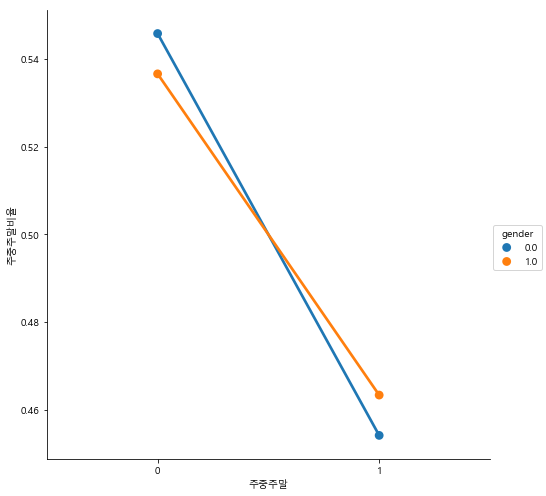

In [26]:
hds3_train_r2 = hds3_train.groupby(['주중주말','gender'],as_index=False)[['총구매액']].count()
hds3_train_r2.columns = ["주중주말","gender","합계"]
ls =[]
for i in range(0,len(hds3_train_r2)) : 
    if hds3_train_r2['gender'][i]== 0 : 
        ls.append(hds3_train_r2['합계'][i]/hds3_train_r2.loc[hds3_train_r2['gender']== 0,'합계'].sum())
    else :
        ls.append(hds3_train_r2['합계'][i]/hds3_train_r2.loc[hds3_train_r2['gender']== 1,'합계'].sum())
hds3_train_r2['주중주말비율'] = ls
sns.factorplot("주중주말","주중주말비율",hue="gender", data = hds3_train_r2,size=7)

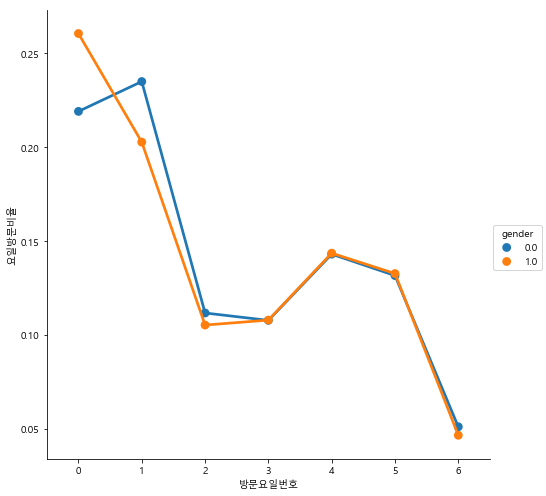

In [25]:
hds3_train_r3 = hds3_train.groupby(['방문요일번호','gender'],as_index=False)[['총구매액']].count()
hds3_train_r3.columns = ["방문요일번호","gender","합계"]
lst2 =[]
for i in range(0,len(hds3_train_r3)) : 
    if hds3_train_r3['gender'][i]== 0 : 
        lst2.append(hds3_train_r3['합계'][i]/hds3_train_r3.loc[hds3_train_r3['gender']== 0,'합계'].sum())
    else :
        lst2.append(hds3_train_r3['합계'][i]/hds3_train_r3.loc[hds3_train_r3['gender']== 1,'합계'].sum())
hds3_train_r3['요일방문비율'] = lst2
sns.factorplot("방문요일번호","요일방문비율",hue="gender", data = hds3_train_r3,size=7)

### 주구매 코너의 남녀 구성 비율을 보기 위한 코드

In [17]:
# 구매 코너별로 따로 코드를 부여하여 처음부터 51번째까지의 코너를 가져와서 남녀간의 분포 확인
hds3_train_r = hds3_train.groupby(['구매코너번호','gender'],as_index=False)[['총구매액']].count()
hds3_train_r.columns = ["구매코너번호","gender","합계"]
lst =[]
for i in range(0,len(hds3_train_r)) : 
    if hds3_train_r['gender'][i]== 0 : 
        lst.append(hds3_train_r['합계'][i]/hds3_train_r.loc[hds3_train_r['gender']== 0,'합계'].sum())
    else :
        lst.append(hds3_train_r['합계'][i]/hds3_train_r.loc[hds3_train_r['gender']== 1,'합계'].sum())
hds3_train_r['구매코너비율'] = lst

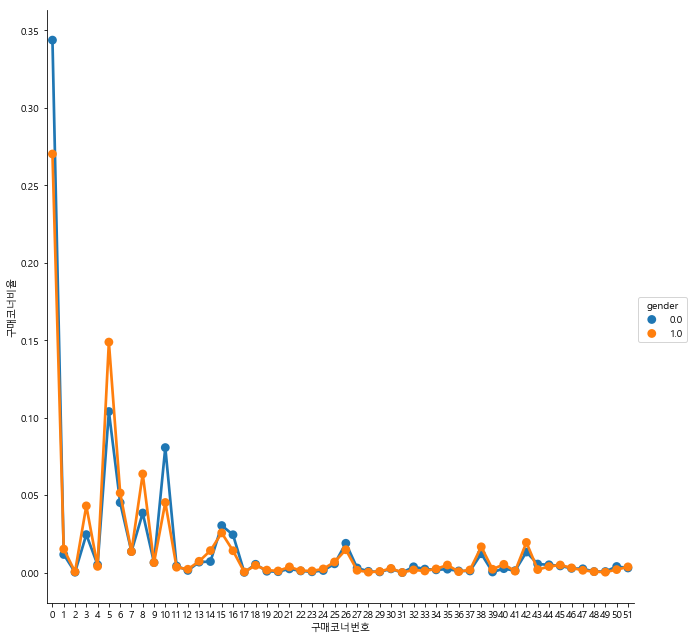

In [18]:
hds3_train2 = hds3_train_r.query(" 구매코너번호 <52")
sns.factorplot("구매코너번호","구매코너비율",hue="gender", data = hds3_train2,size=9)

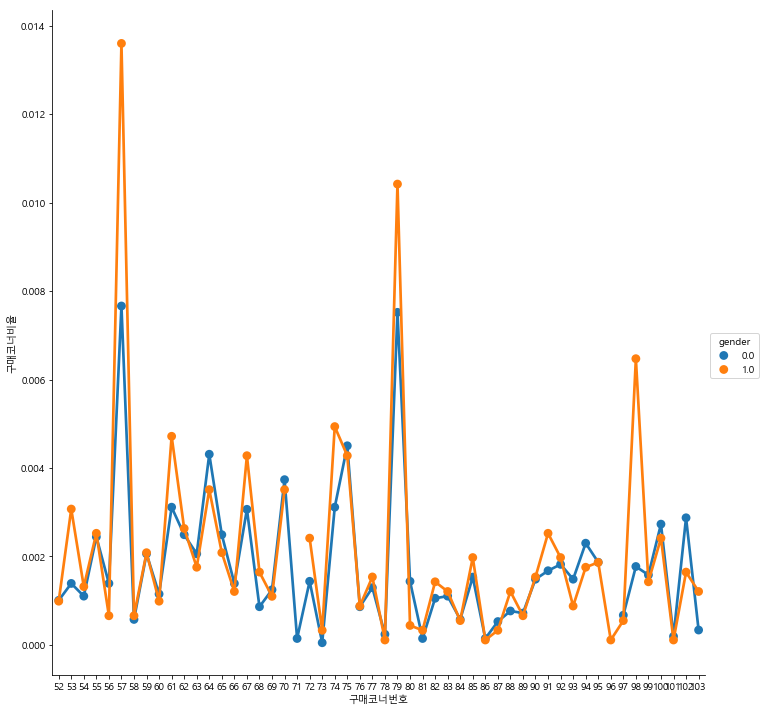

In [19]:
# 52번부터 103번까지의 코너번호를 가진 것들의 남성 여성의 비율 확인 
hds3_train3 = hds3_train_r.query(" 52<=구매코너번호 <104")
sns.factorplot("구매코너번호","구매코너비율",hue="gender", data = hds3_train3,size=10)

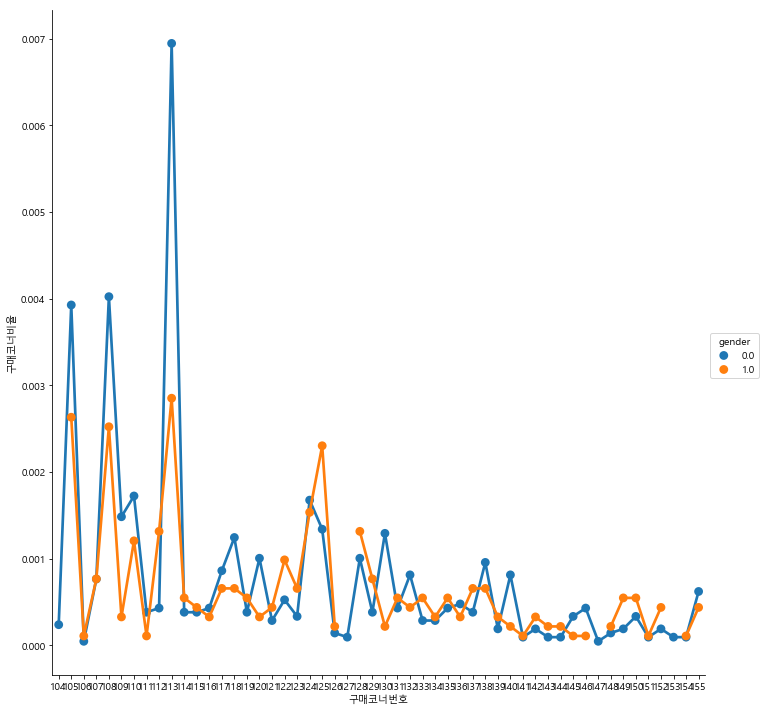

In [20]:
# 104번부터 155번까지의 구매코너번호를 가진 코너들의 남녀 성비 확인 
hds3_train4 = hds3_train_r.query(" 104<=구매코너번호 <156")
sns.factorplot("구매코너번호","구매코너비율",hue="gender", data = hds3_train4,size=10)

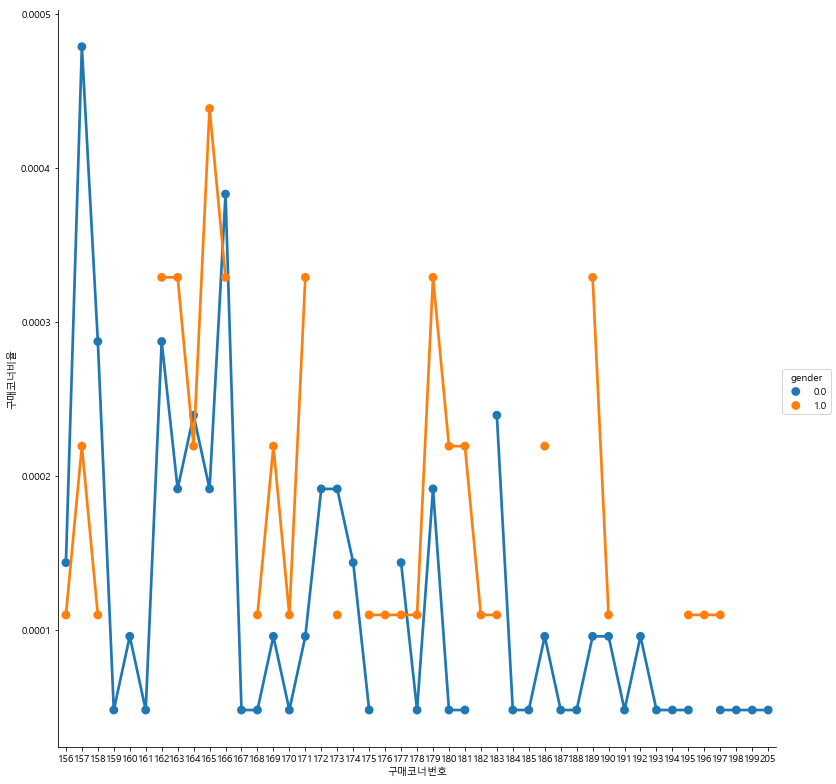

In [21]:
# 156번부터의 주구매코너번호를 가진 코너들의 남녀 성비 확인  
hds3_train5 = hds3_train_r.query(" 156<=구매코너번호")
sns.factorplot("구매코너번호","구매코너비율",hue="gender", data = hds3_train5,size=11)

주구매 코너까지 보았을때 몇개의 코너가 남녀간의 구성비율에 있어 명확한 차이를 보임을 알 수 있다.


또한 범주형의 갯수가 많을수록 그래프를 그리고 처리하기 힘들지만 효과적인 변수가 있다.


그래서 우리는 여기서 따로 표현해주지는 않지만 브랜드도 전부 펼치기로 결정하였다.

# 연속형 변수를 가지고 EDA하기
## 연속형변수를 통해 남녀 구성비율의 차이가 나는지 확인

In [27]:
hds3_train['amount_band']=0

hds3_train.loc[hds3_train['총구매액']<=2500000,'amount_band']=0
hds3_train.loc[(hds3_train['총구매액']>2500000)&(hds3_train['총구매액']<=5000000),'amount_band']=1
hds3_train.loc[(hds3_train['총구매액']>5000000)&(hds3_train['총구매액']<=10000000),'amount_band']=2
hds3_train.loc[(hds3_train['총구매액']>10000000)&(hds3_train['총구매액']<=20000000),'amount_band']=3
hds3_train.loc[(hds3_train['총구매액']>20000000)&(hds3_train['총구매액']<=30000000),'amount_band']=4
hds3_train.loc[(hds3_train['총구매액']>30000000)&(hds3_train['총구매액']<=40000000),'amount_band']=5
hds3_train.loc[(hds3_train['총구매액']>40000000)&(hds3_train['총구매액']<=50000000),'amount_band']=6
hds3_train.loc[hds3_train['총구매액']>50000000,'amount_band']=7

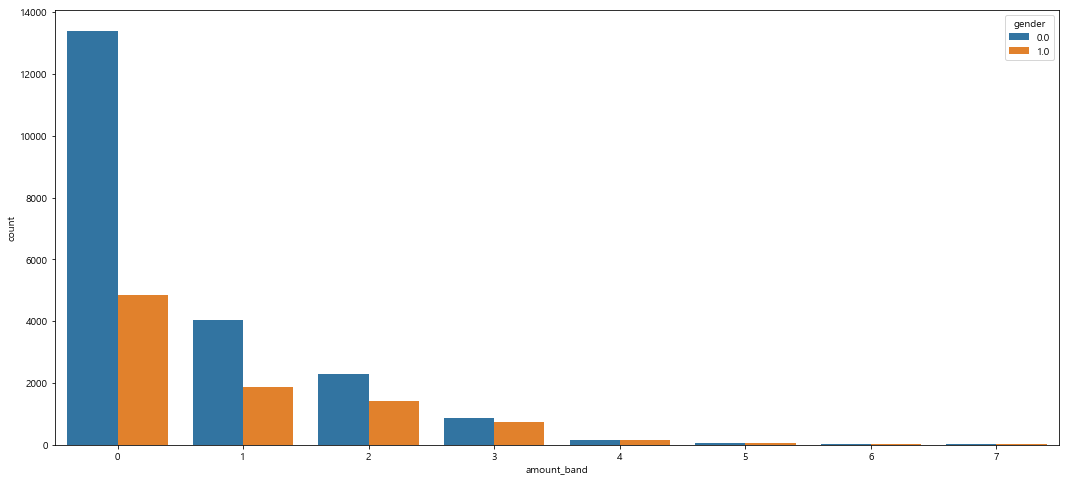

In [28]:
f,ax=plt.subplots(1,1,figsize=(18,8))
sns.countplot("amount_band",hue="gender", data = hds3_train)

In [30]:
hds3_train['amount_band'].value_counts().to_frame()
hds3_train.groupby(['amount_band'])['gender'].mean().to_frame()

,gender
amount_band,
0,0.265911
1,0.316715
2,0.379774
3,0.454883
4,0.509554
5,0.458716
6,0.312500
7,0.617647


C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


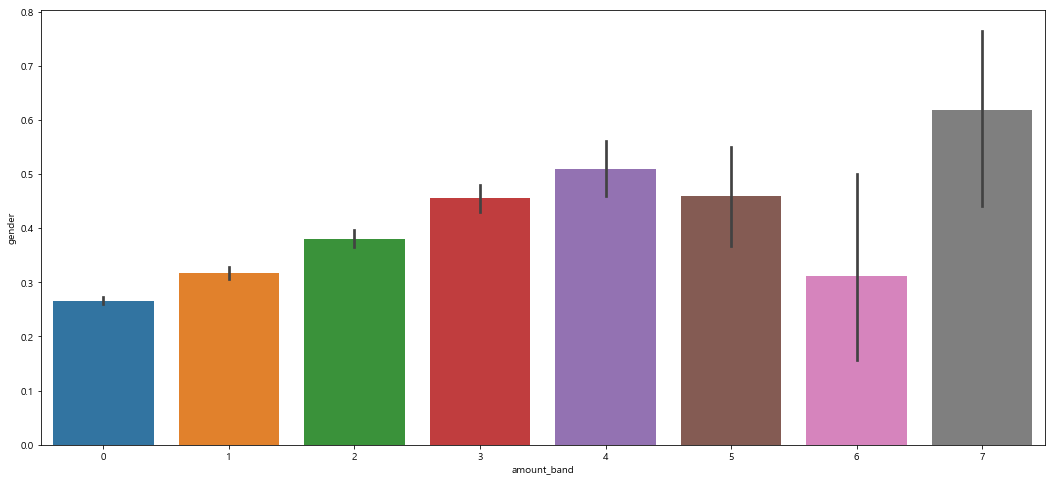

In [29]:
# 총구매액을 구간으로 나누어서 실제 남녀 성비 확인.
f,ax=plt.subplots(1,1,figsize=(18,8))
sns.barplot("amount_band","gender", data = hds3_train)

C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


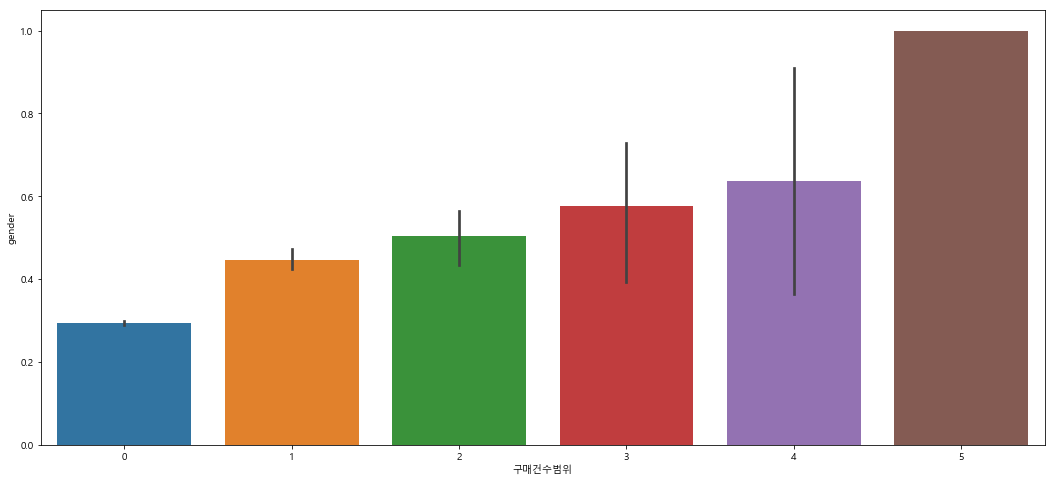

In [31]:
# 총 구매건수가 증가할 수록 남자 구성비율이 증가함을 볼 수 있음 -> 좋은 feature임을 확인 
hds3_train['구매건수범위']=pd.qcut(hds3_train['총구매건수'],4)
hds3_train.groupby(['구매건수범위'])['gender'].mean().to_frame().style.background_gradient(cmap='summer_r')
hds3_train['구매건수범위']=0
hds3_train.loc[hds3_train['총구매건수']<=100,'구매건수범위']=0
hds3_train.loc[(hds3_train['총구매건수']>100)&(hds3_train['총구매건수']<=200),'구매건수범위']=1
hds3_train.loc[(hds3_train['총구매건수']>200)&(hds3_train['총구매건수']<=300),'구매건수범위']=2
hds3_train.loc[(hds3_train['총구매건수']>300)&(hds3_train['총구매건수']<=400),'구매건수범위']=3
hds3_train.loc[(hds3_train['총구매건수']>400)&(hds3_train['총구매건수']<=500),'구매건수범위']=4
hds3_train.loc[hds3_train['총구매건수']>500,'구매건수범위']=5
hds3_train.groupby(['구매건수범위'])['gender'].mean().to_frame().style.background_gradient(cmap='summer_r')
f,ax=plt.subplots(1,1,figsize=(18,8))
sns.barplot("구매건수범위","gender", data = hds3_train)

C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


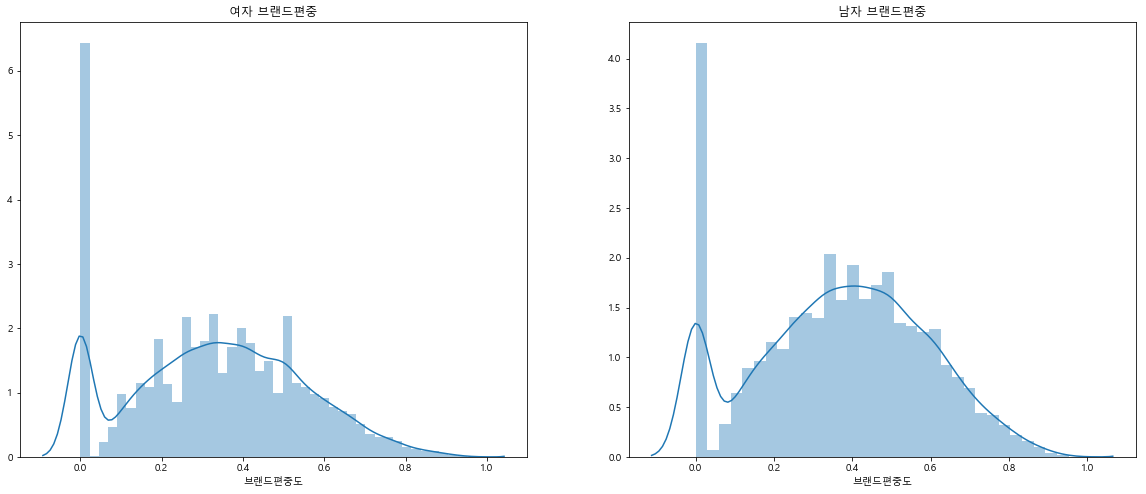

In [32]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.distplot(hds3_train[hds3_train['gender']==0].브랜드편중도,ax=ax[0])
ax[0].set_title('여자 브랜드편중')
sns.distplot(hds3_train[hds3_train['gender']==1].브랜드편중도,ax=ax[1])
ax[1].set_title('남자 브랜드편중')
plt.show()

C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


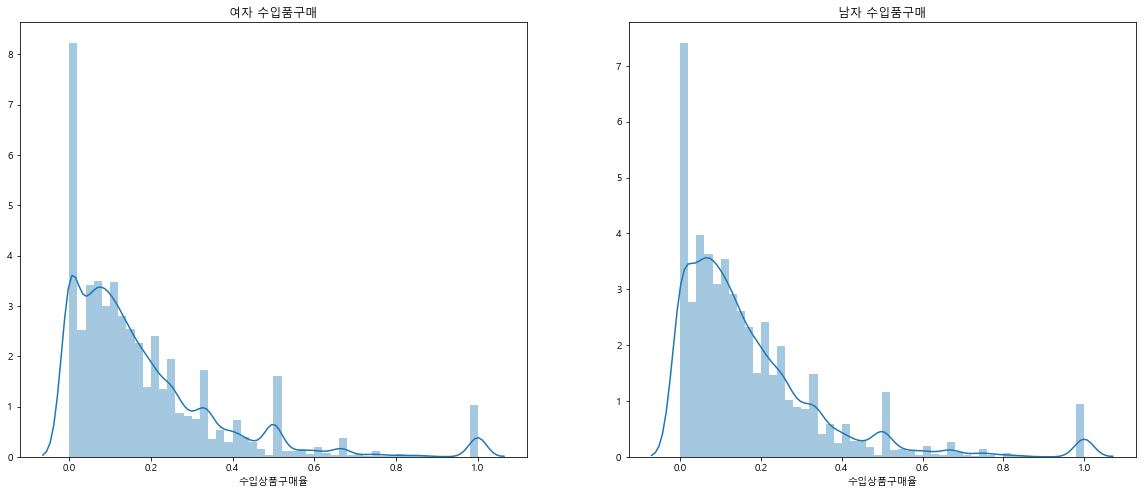

In [33]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.distplot(hds3_train[hds3_train['gender']==0].수입상품구매율,ax=ax[0])
ax[0].set_title('여자 수입품구매')
sns.distplot(hds3_train[hds3_train['gender']==1].수입상품구매율,ax=ax[1])
ax[1].set_title('남자 수입품구매')
plt.show()

C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


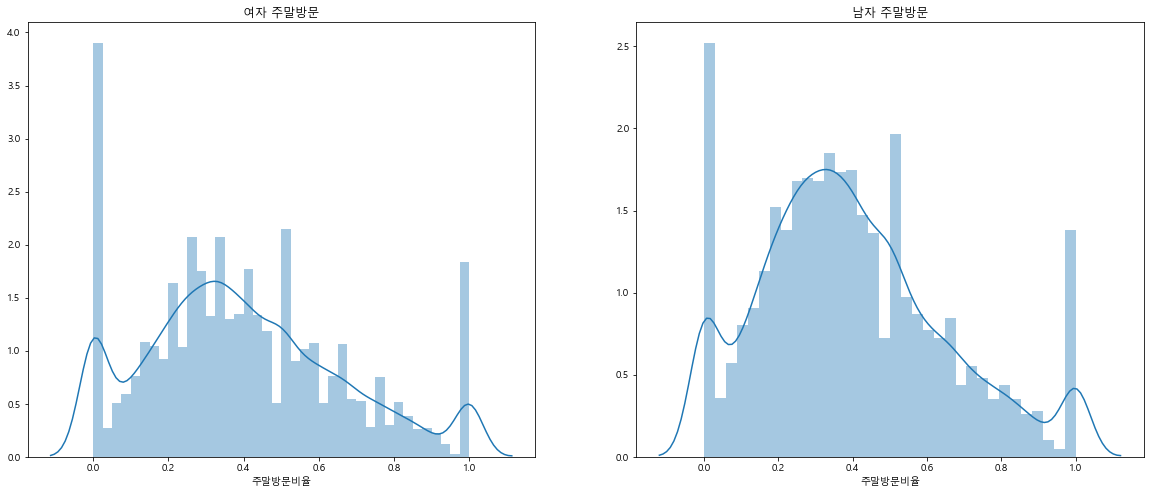

In [34]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.distplot(hds3_train[hds3_train['gender']==0].주말방문비율,ax=ax[0])
ax[0].set_title('여자 주말방문')
sns.distplot(hds3_train[hds3_train['gender']==1].주말방문비율,ax=ax[1])
ax[1].set_title('남자 주말방문')
plt.show()

C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\hyoun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


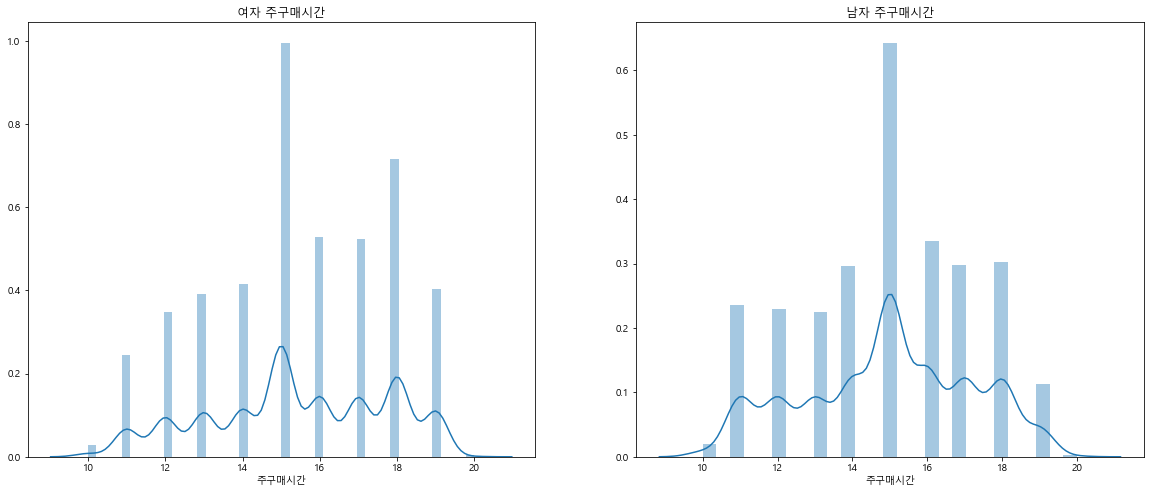

In [35]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.distplot(hds3_train[hds3_train['gender']==0].주구매시간,ax=ax[0])
ax[0].set_title('여자 주구매시간')
sns.distplot(hds3_train[hds3_train['gender']==1].주구매시간,ax=ax[1])
ax[1].set_title('남자 주구매시간')
plt.show()

C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


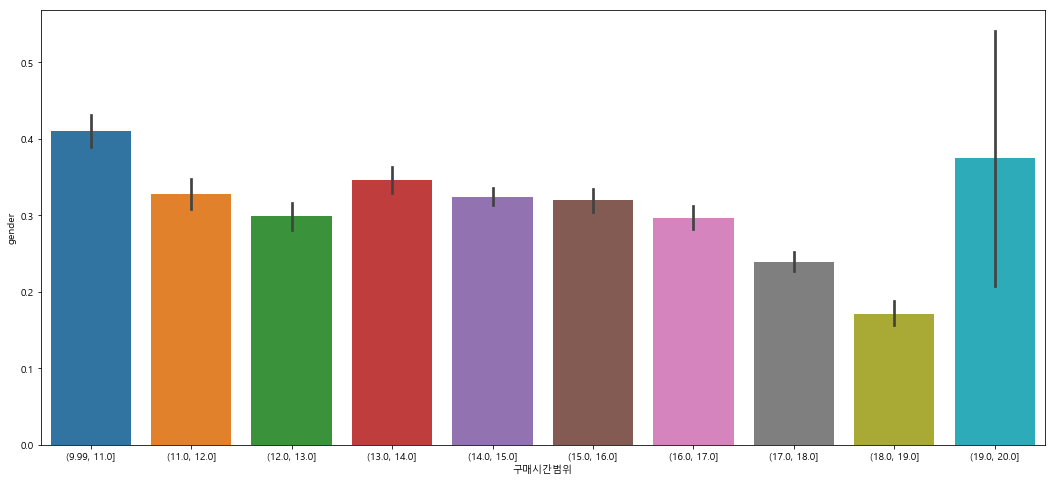

In [36]:
# 주구맷간에 따른 남녀 성비를 비교해보기
hds3_train_z = hds3_train[hds3_train['주구매시간']>0]
hds3_train_z['구매시간범위']=pd.cut(hds3_train_z.주구매시간,10)
f,ax=plt.subplots(1,1,figsize=(18,8))
sns.barplot("구매시간범위","gender", data = hds3_train_z)

C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


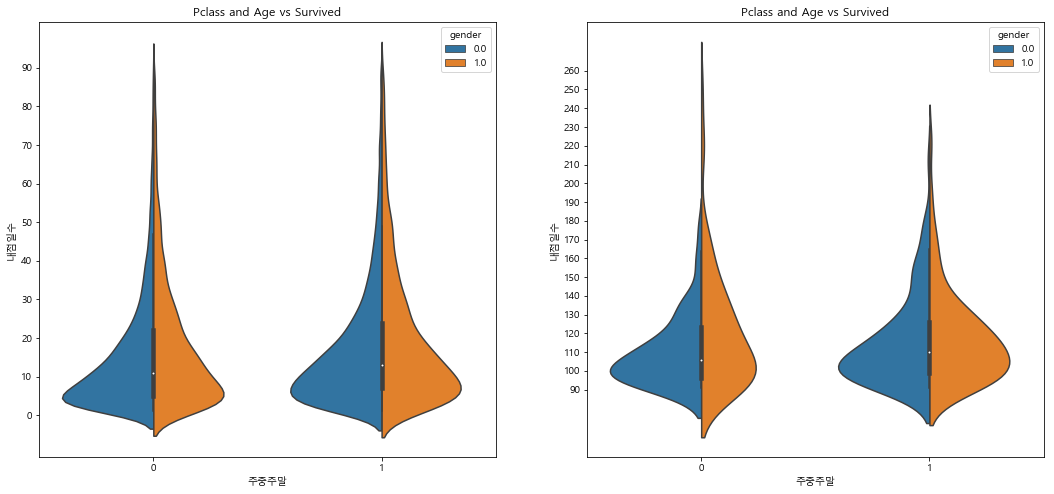

In [37]:
# 주중 주말 구분을 통해 실제로 남녀간의 분포차이를 한눈에 보기 위해 바이올린 플랏을 그림
hds3_train_z2 = hds3_train_z[hds3_train_z['내점일수']<=90]
hds3_train_z3 = hds3_train_z[hds3_train_z['내점일수']>90]
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("주중주말","내점일수", hue="gender", data=hds3_train_z2,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,91,10))
sns.violinplot("주중주말","내점일수", hue="gender", data=hds3_train_z3,split=True,ax=ax[1])
ax[1].set_title('Pclass and Age vs Survived')
ax[1].set_yticks(range(90,270,10))
plt.show()

C:\Users\hyoun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\hyoun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hyoun\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

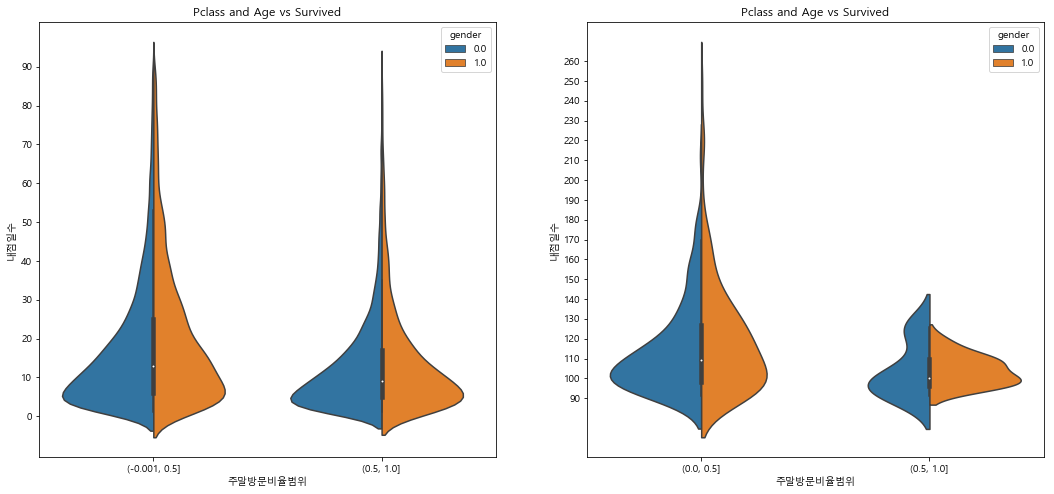

In [39]:
# 주말 방문 비율을 0.5이상과 미만으로 구분하여 실제 우리가 NULL값을 잘 채웠는지 확인 및 분포의 비교를 위해 그림
hds3_train_z2['주말방문비율범위'] = pd.cut(hds3_train_z2.주말방문비율, 2)
hds3_train_z3['주말방문비율범위'] = pd.cut(hds3_train_z3.주말방문비율, bins=[0,0.5,1])
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("주말방문비율범위","내점일수", hue="gender", data=hds3_train_z2,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,91,10))
sns.violinplot("주말방문비율범위","내점일수", hue="gender", data=hds3_train_z3,split=True,ax=ax[1])
ax[1].set_title('Pclass and Age vs Survived')
ax[1].set_yticks(range(90,270,10))
plt.show()

# 4. 데이터 분할

In [9]:
X = pd.merge(hds,y_custid,on='custid')
X_train = X.drop(['gender','custid'],axis=1)
y_train = X['gender']

In [10]:
len(X_train)

30000

In [69]:
X_train.columns = np.arange(0,len(X_train.columns)) # columns 한글로 만들기 LightGBM돌리기 위해서
hds_test.columns = np.arange(0,len(hds_test.columns))

In [12]:
from sklearn.model_selection import train_test_split
X_tra, X_test, y_tra, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

# 5. 최소 성능 평가 (roc_auc_socre)

In [13]:
from sklearn.dummy import DummyClassifier # Dummy 많은쪽으로 찍는것. 분류할때 데이터가 많은 쪽으로 구분짓는다는 의미.
from sklearn.metrics import roc_auc_score
print(y_test.value_counts())
# 여기에 scroe 점수도 넣어보자 -> score와 roc_auc_score의 차이를 알려주는 것임. 
roc_auc_score(y_test,DummyClassifier(strategy='most_frequent').fit(X_tra,y_tra).predict_proba(X_test)[:,1])

0    2131
1     869
Name: gender, dtype: int64


0.5

# 6. 모델 Selection

In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [15]:
random_state = 2
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(CatBoostClassifier(random_state=random_state,iterations=30))
classifiers.append(LGBMClassifier(random_state=random_state))

In [16]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring='roc_auc', cv = 5, n_jobs=-1))

In [17]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [18]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","XGBoosting",'Catboosting','LightGBMboosting']})

In [19]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.541748,0.006165,DecisionTree
1,0.539404,0.008062,AdaBoost
2,0.583131,0.005998,RandomForest
3,0.595885,0.008087,ExtraTrees
4,0.663569,0.004987,GradientBoosting
5,0.501434,0.026656,MultipleLayerPerceptron
6,0.531323,0.007951,KNeighboors
7,0.501002,0.005920,LogisticRegression
8,0.664042,0.004326,XGBoosting
9,0.657152,0.005543,Catboosting


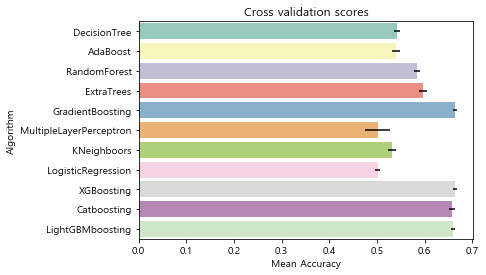

In [20]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## GradientBoosting,XGBboosting,  LightGBM 선정

# 7. Model Tunning GridSearch

In [21]:
random_state = 2
classifiers1 = []
classifiers1.append(GradientBoostingClassifier(random_state=random_state))
classifiers1.append(XGBClassifier(random_state=random_state))
#classifiers1.append(CatBoostClassifier(random_state=random_state,iterations=5))
classifiers1.append(LGBMClassifier(random_state=random_state))

In [22]:
Gradient_para = {'loss':['deviance','exponential'],
                'learning_rate':[0.1,0.15,0.2,0.3]}
xgb_para = {'gamma':[0.01,0.1,1,10,100],
           'max_depth':range(3,16,2),
           'learning_rate':[0.01,0.1,0.2,0.3]}
#cat_para = {'depth':range(3,16,2),
#           'learning_rate':[0.01,0.1,0.2]}
LGBM_para = {'max_depth':range(3,16,2), 'learning_rate':[0.01,0.1,0.2,0.3],
            'min_data_in_leaf':range(10,41,10)}
grid_score = []

In [23]:
grid_search_gradi = GridSearchCV(classifiers1[0],Gradient_para, cv=5, n_jobs=-1)
grid_search_gradi.fit(X_tra,y_tra)
grid_score.append(roc_auc_score(y_test,grid_search_gradi.predict_proba(X_test)[:,1]))
print(grid_score[0])
print(grid_search_gradi.best_estimator_)

0.675258486293895
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=2,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [24]:
grid_search_xgb = GridSearchCV(classifiers1[1],xgb_para, cv=5, n_jobs=-1)
grid_search_xgb.fit(X_tra,y_tra)
grid_score.append(roc_auc_score(y_test,grid_search_xgb.predict_proba(X_test)[:,1]))
print(grid_score[1])
print(grid_search_xgb.best_estimator_)

0.6696783575678016
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


### catboosting model을 돌리면 memory 문제가 발생해서 실행할 수 가 없었음 그래서 그냥 원본 데이터를 가지고 나중에 효과를 비교할 예정임.

grid_search_cat = GridSearchCV(classifiers1[2],cat_para, cv=5, n_jobs=-1)
grid_search_cat.fit(X_tra,y_tra)
grid_score.append(roc_auc_score(y_test,grid_search_cat.predict_proba(X_test)[:,1]))
print(grid_score[2])
print(grid_search_cat.best_estimator_)

In [25]:
grid_search_LGBM = GridSearchCV(classifiers1[2],LGBM_para, cv=5, n_jobs=-1)
grid_search_LGBM.fit(X_tra,y_tra)
grid_score.append(roc_auc_score(y_test,grid_search_LGBM.predict_proba(X_test)[:,1]))
print(grid_score[2])
print(grid_search_LGBM.best_estimator_)

0.6743745001590312
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=3,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=2, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)


## Grid Search 후 성능 확인 'roc auc'

In [26]:
grid_model_res = pd.DataFrame({"Grid_Score":grid_score,"Algorithm":["GradientBoosting","xgboosting","LGBMboosting"]})

## Grid Search 후 찾은 최적의 모델 scores

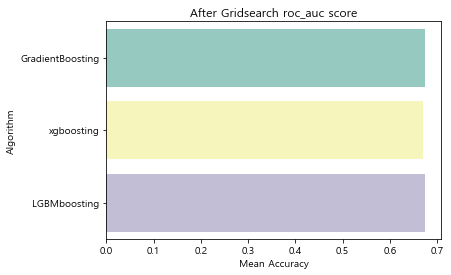

In [27]:
g_grid = sns.barplot("Grid_Score","Algorithm",data = grid_model_res, palette="Set3",orient = "h")
g_grid.set_xlabel("Mean Accuracy")
g_grid = g_grid.set_title("After Gridsearch roc_auc score")

# 8. Model Tunning Random Search

In [28]:
import scipy as sp
import scipy.stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

Gradient_para_rand = {'loss':['deviance','exponential'],
                'learning_rate':sp.stats.uniform()}
xgb_para_rand= {'gamma':sp_randint(1, 1000),
           'max_depth':sp_randint(1, 30),
           'learning_rate':sp.stats.uniform()}
#cat_para_rand = {'depth':sp_randint(3, 16),
#           'learning_rate':sp.stats.uniform()}
LGBM_para_rand = {'max_depth':sp_randint(3, 40), 'learning_rate':sp.stats.uniform(),
            'min_data_in_leaf':sp_randint(5, 100)}
Random_score = []

In [29]:
random_search_gradi = RandomizedSearchCV(classifiers1[0],param_distributions=Gradient_para_rand,n_iter=10, random_state=2, n_jobs=-1)
random_search_gradi.fit(X_tra,y_tra)
Random_score.append(roc_auc_score(y_test,random_search_gradi.predict_proba(X_test)[:,1]))
print(Random_score[0])
print(random_search_gradi.best_estimator_)

C:\Users\hyoun\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.679692457065652
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.11995054259638982, loss='exponential',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=2,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [31]:
random_search_xgb = RandomizedSearchCV(classifiers1[1],param_distributions=xgb_para_rand, n_iter=10, random_state=2, n_jobs=-1)
random_search_xgb.fit(X_tra,y_tra)
Random_score.append(roc_auc_score(y_test,random_search_xgb.predict_proba(X_test)[:,1]))
print(Random_score[1])
print(random_search_xgb.best_estimator_)

C:\Users\hyoun\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6164385780837319
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=125, learning_rate=0.8182267213548875,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=2, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


### Catboosting 기법은 memory문제 발생하기 때문에 randomsearching도 하지 않음.

random_search_cat = RandomizedSearchCV(classifiers1[2],param_distributions=cat_para_rand, n_iter=10, random_state=2, n_jobs=-1)
random_search_cat.fit(X_tra,y_tra)
Random_score.append(roc_auc_score(y_test,random_search_cat.predict_proba(X_test)[:,1]))
print(Random_score[2])
print(random_search_cat.best_estimator_)

In [32]:
random_search_LGBM = RandomizedSearchCV(classifiers1[2],param_distributions=LGBM_para_rand, n_iter=10, random_state=2, n_jobs=-1)
random_search_LGBM.fit(X_tra,y_tra)
Random_score.append(roc_auc_score(y_test,random_search_LGBM.predict_proba(X_test)[:,1]))
print(Random_score[2])
print(random_search_LGBM.best_estimator_)

C:\Users\hyoun\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6739163069791705
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.11619331759609963,
        max_depth=5, min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=85, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=2,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)


## Random Search 후 성능 확인 'roc auc'

In [34]:
Random_model_res = pd.DataFrame({"Random_Score":Random_score,"Algorithm":["GradientBoosting","xgboosting","LGBMboosting"]})
Random_model_res

,Random_Score,Algorithm
0,0.679692,GradientBoosting
1,0.616439,xgboosting
2,0.673916,LGBMboosting


## Random Search 후 찾은 최적의 모델 'roc auc'

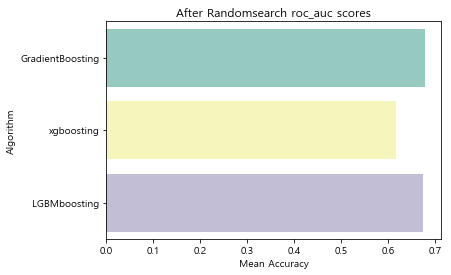

In [35]:
g_rand = sns.barplot("Random_Score","Algorithm",data = Random_model_res, palette="Set3",orient = "h")
g_rand.set_xlabel("Mean Accuracy")
g_rand = g_rand.set_title("After Randomsearch roc_auc scores")

## 9. 모델 튜닝 전 vs Grid Search 후 vs Random Search 후 roc_auc_score 비교

AxesSubplot(0.125,0.657941;0.775x0.222059)
AxesSubplot(0.125,0.391471;0.775x0.222059)
AxesSubplot(0.125,0.125;0.775x0.222059)


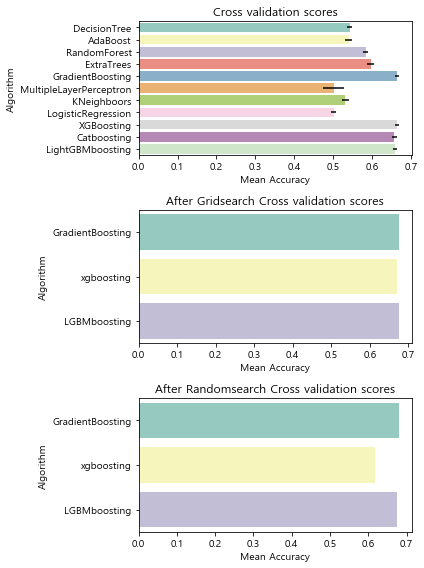

In [36]:
f1 = plt.figure(figsize=(6, 8))
# 모델 튜닝 전
ax1 = plt.subplot(311)
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
print(ax1)

# Grid Search 후
ax2 = plt.subplot(312)
g_grid = sns.barplot("Grid_Score","Algorithm",data = grid_model_res, palette="Set3",orient = "h")
g_grid.set_xlabel("Mean Accuracy")
g_grid = g_grid.set_title("After Gridsearch Cross validation scores")
print(ax2)

# Random Search 후
ax3 = plt.subplot(313)
g_rand = sns.barplot("Random_Score","Algorithm",data = Random_model_res, palette="Set3",orient = "h")
g_rand.set_xlabel("Mean Accuracy")
g_rand = g_rand.set_title("After Randomsearch Cross validation scores")
print(ax3)

plt.tight_layout()

# 10. Grid Search 와 Random Search한 모델중 모델별로 좋은 모델을 선택함

In [37]:
# 여기에 튜닝 전의 값도 삽입해서 비교해보자..
accuracydata = pd.merge(grid_model_res,Random_model_res,on='Algorithm')
accuracydata

,Grid_Score,Algorithm,Random_Score
0,0.675258,GradientBoosting,0.679692
1,0.669678,xgboosting,0.616439
2,0.674375,LGBMboosting,0.673916


## 10-1 VotingClassifier 이용 Model Ensemble

In [63]:
# Model ensemble

from sklearn.ensemble import VotingClassifier

averaging = VotingClassifier(
    estimators = [('GradientBoosting', random_search_gradi),("XGBBoosing", grid_search_xgb),
                  ("LightGBMBoosting", grid_search_LGBM)],
    voting = 'soft')
averaging.fit(X_train, y_train)

In [50]:
best_gradi = random_search_gradi.best_estimator_
best_xgb = grid_search_xgb.best_estimator_
best_LGBM = grid_search_LGBM.best_estimator_
best_gradi.fit(X_train,y_train)
best_xgb.fit(X_train,y_train)
best_LGBM.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=3,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=20,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=2, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

# 11. 제출파일에 적용 
## Voting 기법보다 기하평균이 더 좋다는 의견이 많이 있어 기하평균의 데이터를 제출하도록 합의함.

In [70]:
final1['target'] = averaging.predict_proba(hds_test)[:,1]

In [71]:
final2['gradi'] = best_gradi.predict_proba(hds_test)[:,1]
final2['xgb'] = best_xgb.predict_proba(hds_test)[:,1]
final2['LGBM'] = best_LGBM.predict_proba(hds_test)[:,1]

In [73]:
final2['gender'] = (final2['gradi']*final2['xgb']*final2['LGBM'])**(1/3)

,custid,gradi,xgb,LGBM,target
26316,30000,0.242850,0.241197,0.242251,0.242098
26317,30001,0.371447,0.402947,0.387978,0.387243
26318,30002,0.328357,0.281262,0.324554,0.310633
26319,30003,0.259564,0.280485,0.266692,0.268774
26320,30004,0.294618,0.307529,0.304361,0.302119


In [75]:
final2[['custid','gender']].to_csv('김태현-문성민submission.csv',index=False)

# 12. 모델 저장

In [65]:
from sklearn.externals import joblib # 모형저장. 

joblib.dump(averaging, 'competition_voting_model.sav')
joblib.dump(best_gradi, 'best_gradi_model.sav')
joblib.dump(best_xgb, 'best-xgb_model.sav')
joblib.dump(best_LGBM, 'best_LGBM_model.sav')

['best_LGBM_model.sav']

# 13. 후기

#### 20152640 김태현
 처음 데이터를 받았을때 작년에 사용했던 데이터여서 그렇게 많이 힘들것 같지 않았다. 하지만 우리가 작년에 했던것은 Feature Engineering까지 했던것이었고 이번의 결과는 직접 모델링을 수행하고 최선의 모델을 뽑고 모델튜닝까지 였다.
 처음에 모델을 뽑고 튜닝하는데 뭐 별거 있어 라는 생각을 가지고 했지만 feature를 찾아보고 점점 깊게 분석해가면서 어려움을 느끼기 시작하였다. 그리고 모델을 튜닝할 때 점점 시간이 걸리고 오류가 발생할때마다 포기하고 싶은 생각이 들었다. 
 
 그렇지만 어느정도 해결하고 난 후 ML과정의 전체적인 과정을 다룰 수 있어 좋았다. 
 
 이번 miniproject를 하면서 아쉬운점은 처음에 GridSearch를 하고 RandomSearch를 한것이다. 모델을 다 돌리고 Search를 하고난 후 스스로 그런 생각이 들었다. RandomSearch를 하고 그 주변을 GridSearch를 하는것이 더 좋지 않았을까. 더 효율적이지 않았을까.. 
 
 처음으로 처음부터 끝까지 과정을 진행하면서 아쉬움도 많이 느끼고 보람도 많이 느낀것 같다.

#### 20152643 문성민

굉장히 고민과 걱정을 많이 했다. 파이썬에 대해 감을 찾고 있는 중이었고 같은 팀인 태현이에게 폐가 되지 않아야겠다는 마음가짐으로 과제에 임했다.

제일 먼저 데이터를 받고 고민 했던점은 남자와 여자의 성 비율이 대략 3:7으로 차이가 났다는 것이다. 이는 count plot을 포함한 다양한 시각화를 했을 때 여자가 대부분의 분야에서 압도적인 양을 보이게 되었고 이를 해결하기 위해 비율을 사용하기로 하였다. 그 후 기존의 feature들이 생각보다 좋은 것이 별로 없어 feature를 10개정도 생성했지만 대부분이 무의미해 날려버리는 과정을 반복하면서 다음 학습때는 의미있는 feature를 생성하기는 힘들겠지만 적어도 의미없는 feature를 생성하는 양이 줄어들 것이라고 생각한다.


 모델에 적용시킬떼 내 노트북에 심각함을 알게되었고 무작정 Grid Search를 하는 것이 과연 좋은 것일까... 모델을 돌릴때도 신중을 가해야 하는 것 같다.